# Psytrack Tutorial

References to the paper ***Efficient inference for time-varying behavior during learning*** published in NeurIPS 2018

Link to paper: http://pillowlab.princeton.edu/pubs/Roy18_NeurIPS_dynamicPsychophys.pdf

---

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

import psytrack as psy

# Quick Start
This is a quick demonstration of Psytrack with a simulated dataset.

\*\* **Please find a much more in-depth tutorial using real data below** \*\*


### Generate simulated data

sigma^2 associated with each weight:   2^[-4. -5. -6. -7.]
number of beahvioral realizations (y's) generated and stored:    1
weights generated:


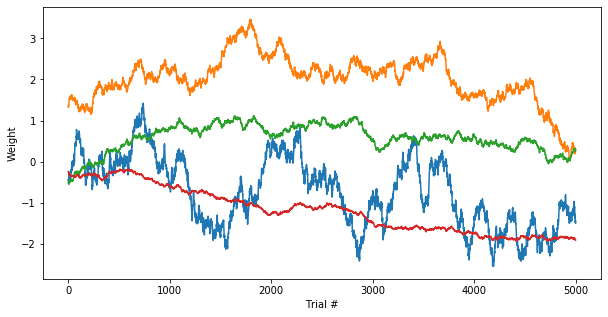

In [8]:
seed = 31
num_weights = 4
num_trials = 5000
hyper = {'sigma'   : 2**np.array([-4.0,-5.0,-6.0,-7.0]),
         'sigInit' : 2**np.array([ 0.0, 0.0, 0.0, 0.0])}

### Compute
simData = psy.generateSim(K=num_weights, N=num_trials, hyper=hyper,
                          boundary=6.0, iterations=1, seed=seed, savePath=None)

print("sigma^2 associated with each weight:   2^" + str(np.log2(simData['sigma'])))
print("number of beahvioral realizations (y's) generated and stored:   ", len(simData['all_Y']))
print("weights generated:")

plt.figure(figsize=(10,5))
plt.plot(simData['W'])
plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
plt.xlim(0,5000); plt.ylim(-3.6,3.6)
plt.xlabel("Trial #"); plt.ylabel("Weight");

### Recover weights from simulated behavior (60 sec)

In [9]:
rec = psy.recoverSim(simData)

Processing time: 0:00:55.234307


### Plot recovered weights over true weights

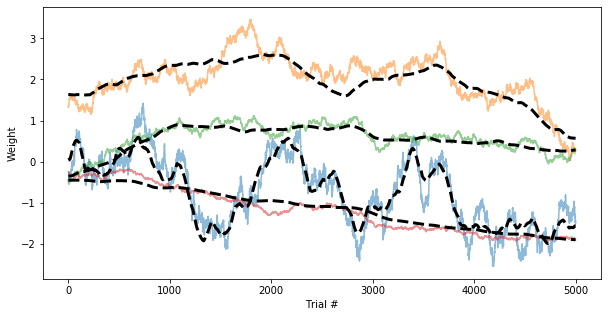

In [10]:
# Display recovered weights overlaid on real weights
plt.figure(figsize=(10,5))
plt.plot(simData['W'], linestyle="-", alpha=0.5)
plt.plot(rec['wMode'].T, linestyle="--", lw=3, color="black")
plt.xlabel("Trial #"); plt.ylabel("Weight");

### Plot recovered hyperparameters over true hyperparameters

Text(0, 0.5, '$\\log_2(\\sigma)$')

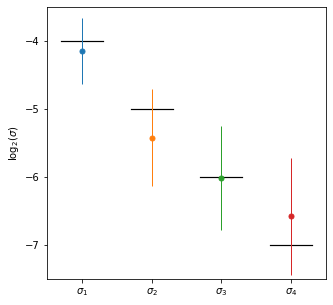

In [15]:
true_sigma = np.log2(rec['input']['sigma'])
avg_sigma = np.log2(rec['hyp']['sigma'])
err_sigma = rec['hess_info']['hyp_std']

plt.figure(figsize=(5,5))
for i in range(num_weights):
    plt.plot([i-0.3, i+0.3], [true_sigma[i]]*2, color="black", linestyle="-", lw=1.2, zorder=0)
    plt.errorbar([i], avg_sigma[i], yerr=2*err_sigma[i], lw=1, marker='o', markersize=5)

plt.xticks([0,1,2,3]); plt.yticks(np.arange(-8,-2))
plt.gca().set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$"])
plt.xlim(-0.5,3.5); plt.ylim(-7.5,-3.5)
plt.ylabel(r"$\log_2(\sigma)$");

---
# Full Tutorial with Real Data

Datasets handled by Psytrack are specific to an individual animal and are stored as a Python dictionary

In [16]:
# Extract premade dataset from npz
D = np.load('sampleRatData.npz', allow_pickle=True)['D'].item()

print("The keys of the dict for this example animal:\n   ", list(D.keys()))


The keys of the dict for this example animal:
    ['name', 'y', 'answer', 'correct', 'dayLength', 'inputs']


Of these keys, only `y` and `inputs` are necessary for analysis of the dataset

---

`y` should be a 1D array of the animal's choice on each trial. Currently, the analysis only works for two-alternative forced choice tasks, and so there should only be two options on each trial (error or omission trials are typically discarded from the analysis).

The two options (A or B, Left or Right, etc.) **must** be mapped to 1 and 2 in `y` (not 0 and 1, or -1 and +1). In this example, Left=1 and Right=2.

In [17]:
print("The shape of y:   ", D['y'].shape)
print("The number of trials:   N =", D['y'].shape[0])

print("The unique entries of y:   ", np.unique(D['y']))

The shape of y:    (20000,)
The number of trials:   N = 20000
The unique entries of y:    [1. 2.]


---

`inputs` is itself another dictionary, containing arbitrary keys. Each of these keys represents a _potential_ input into the model and must be a 2D array of shape $(N, M)$ where $N$ is the number of trials. The number of columns $M$ is arbitrary, and the $i^{th}$ column is typically used to encode information from $i$ time steps previous.

For example, in our example data set the key `s1` encodes the (normalized) stimulus values heard on each trial. `s1[7,0]` would encode the stimulus heard on the 7th trial where as both `s1[6,0]` and `s1[7,1]` would encode the stimulus heard on the 6th trial. The information is redundant, but allows for all feasible regressors to predicting behavior of trial $i$ to be accessible by referencing the $i^{th}$ row of the respective input array.

In [18]:
print("The keys of inputs:\n   ", list(D['inputs'].keys()))

print("\nThe shape of s1:", D['inputs']['s1'].shape)
print("s1[7]   : ", D['inputs']['s1'][7])
print("s1[6,0] : ", D['inputs']['s1'][6,0])
print("s1[7,1] : ", D['inputs']['s1'][7,1])


The keys of inputs:
    ['h', 'r', 'c', 's1', 's2', 's_avg']

The shape of s1: (20000, 2)
s1[7]   :  [-0.04184135  0.73846325]
s1[6,0] :  0.738463248564285
s1[7,1] :  0.738463248564285


---

Other keys are for convenience and are _optional_ : `name` stores the name of the animal, `answer` is an easy reference as to what the correct choice was on a given trial (can be inferred from `inputs`), and `correct` is an easy reference as to whether the animal made the correct choice on a given trial (inferred from `inputs` and `y`).

`dayLength` is an array storing the number of trials that occurred in each session of training. Taking a cumulative sum will give you the indices at which each new session begins. This can be useful for post-hoc analysis, and is **not** optional for the analysis if one wishes to use the `sigmaDay` functionality (see Section 3.3 in paper).

---

## Fitting the data

Once you have your data arranged in the proper format, you can now run the analysis! 

The fitting function is called `hyperOpt()` and before using it, you must decide on 3 inputs:

1) `weights` : which of your inputs should you fit

2) `hyper` : what hyperparameters should your model have and how should they be initialized

3) `optList` : what subset of the hyperparameters should be optimized



`weights` is a dictionary where the keys correspond to the keys in your dataset's `inputs` dictionary, and the key values are an integer indicating how many of the columns of that value in `inputs` ought to be used for fitting. You can also include in `weights` the special key `bias` which need not be included in `inputs` --- this will simply create an input of all 1s.

In [19]:
weights = {'bias' : 1,  # a special key
           's1' : 1,    # use only the first column of s1 from inputs
           's2' : 1}    # use only the first column of s2 from inputs

# It is often useful to have the total number of weights K in your model
K = np.sum([weights[i] for i in weights.keys()])


`hyper` is a dictionary that indicates what hyperparameters your model will have. There are 3 types, the only necessary one being `sigma` which controls trial-to-trial variability. Optionally, you may also include `sigInit` which controls the variability on the very first trial (e.g. how close weights must initialize to 0) --- it is often best to include this hyperparameter and set it to a high value as you often prefer the data to determine where the weights ought to initialize. The final optional hyperparameter to include is `sigDay` which controls variability between sessions (that is, between the last trial of one session and the first trial of the next session) --- see Section 3.3 in the paper for more info on `sigDay`.

For each type of hyperparameter included in `hyper`, you must also select an initial value. If you are optimizing over a particular hyperparameter, than the initial value is not so important as the fitting procedure will eventually converge regardless. However, if you are *not* optimizing, then the initial value will be the fixed value of the hyperparameter.

Finally, for each hyperparameter key in `hyper`, you must specify your initializations as a 1D array with length $K$. If you provide only a single value, then the optimizer will assume that you want the same hyperparameter to apply to every weight (as opposed to each weight having it's own).

In [20]:
hyper= {'sigInit' : 2**4.,      
        'sigma' : [2**-4.]*K,   # Each weight will have it't own sigma, but all initialized the same
        'sigDay' : None}        # Not necessary to specify as None, but keeps things general

`optList` is a list of the subset of hyperparameters in `hyper` that you wish to optimize over in your model. It is typically unnecessary to optimize over `sigInit` though you will often wish to provide initial values.

In [21]:
optList = ['sigma']

Now that we have specified `weights`, `hyper`, and `optList`, we can fit our model with `hyperOpt()`! The function takes your dataset `D` and the three additional inputs, and returns 4 things.

1) `hyp` : a dictionary of the optimized hyperparameters

2) `evd` : the approximate model evidence of the optimized model

3) `wMode` : the weights of the optimized model

4) `hess` : a dictionary of sparse terms that relate to the Hessian of the optimal model, and can be used to calculate posterior credible intervals on the weights

Run times will depend on the number of trials $N$ and weights $K$ as well as the number of hyperparameters being fit. Refer to Figure 2 in the paper for a rough idea of how long things ought to take. This ought to take < 2 minutes!

In [22]:
hyp, evd, wMode, hess_info = psy.hyperOpt(D, hyper, weights, optList)

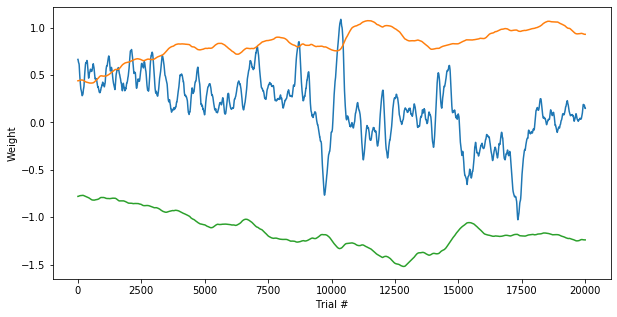

In [23]:
# Let's quickly plot the results!
plt.figure(figsize=(10,5))
plt.plot(wMode.T)
plt.xlabel("Trial #"); plt.ylabel("Weight");

Fortunately, Psytrack includes a much nicer plotting function for visualizing the model

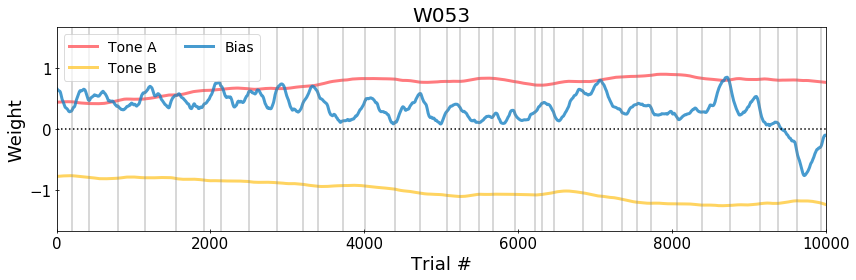

In [24]:
psy.makeWeightPlot(wMode, D, weights, END=10000)

The labels, color scheme, and many other plotting details are hard-coded into `makeWeightPlot()` and so will likely need some adjustment to fit to your specific dataset, but it offers a blueprint and a variety of handy features.

For example, adding credible intervals on the weights can be done, but requires an extra bit of processing on the `hess` returned by `hyperOpt()`

In [25]:
# Replot with 95% posterior credible interval
psy.makeWeightPlot(wMode, D, weights, END=10000, errorbar=credibleInt)

KeyError: 'ddlogprior'

We can also add two subplots with useful information: 

1) A performance plot, tracking the animals task accuracy over time

2) A bias plot, tracking the animal's choice bias over time

Both of these plots will calculate their respective values directly from the data ("empirical") with 2SD error bars, but also overlay the corresponding values as predicted by the model weights ("predicted").

In [26]:
psy.makeWeightPlot(wMode, D, weights, END=10000, errorbar=credibleInt,
                   perf_plot=True, bias_plot=True)

NameError: name 'credibleInt' is not defined

The predictions in the above plot simply use the weight trajectories found by the model which used every trial for fitting. If you wished to make true predictions, you would need to make predictions on trials that were held-out from the fitting procedure. We can do this using the built-in cross-validation functions `Kfold_crossVal()` and `Kfold_crossVal_check()`. This is also useful if you'd like to compare different models via cross-validated log-likelihood rather than approximate model evidence.

`Kfold_crossVal()` receives a dataset and a specified number of cross-validation folds `F` and returns `F` smaller *training* datasets each with a corresponding *test* dataset that contain a random `1/F` of trials from the original dataset. Every trial in the dataset will now be a held-out trial in one of the `F` test sets.

In [27]:
folds = 10 # number of cross-validation folds
trainDs, testDs = psy.Kfold_crossVal(D, F=folds)

Now that the original dataset has been split into `F` pairs of training and testing datasets, we can fit each of the `F` training sets normally. Then using the weights recovered from each training set, we can *infer* the weights on the held-out trials with a simple interpolation between the nearest training trials. This is done in `Kfold_crossVal_check()` which returns the interpolated $\bf{g} \cdot \bf{w}$ for each test trial and the corresponding log-likelihood.

**Note:** This is a computationally expensive procedure due to the fitting of `F` distinct datasets. Expect the cell below to run for 15-20 minutes!

In [ ]:
test_results = []
for k in range(folds):
    print("Running xval fold", k+1)

    _, _, wMode_K, _ = psy.hyperOpt(trainDs[k], hyper, weights, optList)

    logli, gw = psy.Kfold_crossVal_check(testDs[k], wMode_K, trainDs[k]['missing_trials'], weights)

    res = {'logli' : np.sum(logli), 'gw' : gw, 'test_inds' : testDs[k]['test_inds']}
    test_results += [res]

print("Cross-validated log-likelihood of model:", np.sum([i['logli'] for i in test_results]))

psy.makeWeightPlot(wMode, D, weights, END=10000, errorbar=credibleInt,
                   perf_plot=True, bias_plot=True, prediction=test_results)

---
### Other useful things

The `trim()` function can be used to easily slice a dataset with a new start and end trial

The `jacHessCheck()` function can provide a numerical check on the analytical jacobian and hessian calculated by the model

